### Refresher on evaluation metrics:
* Accuracy
* Recall
* Confusion matrix
* ROC 
* AUC 
* Logloss

AUC vs. Logloss
Logloss evaluates model's predictive power, while AUC emphaizes model's ability to rank.

### Load data and trained models

In [1]:
import pickle

In [2]:
# load models
model_lr = pickle.load(open('model_lr.pkl','rb'))
model_grd = pickle.load(open('grd.pkl','rb'))
model_grd_enc = pickle.load(open('grd_enc.pkl','rb'))
model_grd_lm= pickle.load(open('grd_lm.pkl','rb'))

In [4]:
# load data
train_X = pickle.load(open('train_X.pkl','rb'))
train_y = pickle.load(open('train_y.pkl','rb'))
test_X = pickle.load(open('test_X.pkl','rb'))
test_y = pickle.load(open('test_y.pkl','rb'))

In [5]:
# data description
train_X.shape, train_y.shape
test_X.shape,test_y.shape

((534223, 548), (534223,))

((286626, 548), (286626,))

In [6]:
train_X.head()

,weekend,C20_label,C17_label,C19_label,C21_label,site_id1234,site_id123456,site_id_all,site_domain1234,site_domain_all,...,C17_label_1,C17_label_2,C17_label_3,C17_label_4,C19_label_3,C19_label_4,C21_label_1,C21_label_2,C21_label_3,C21_label_4
id,,,,,,,,,,,,,,,,,,,,,
8181827768660016329,0,1,2,1,2,0.235860,0.240617,0.203364,0.320782,0.130076,...,0,1,0,0,0,0,0,1,0,0
12798235348290719618,0,2,4,4,4,0.751854,0.650900,0.533642,0.045982,0.010297,...,0,0,0,1,0,1,0,0,0,1
3584922264180734473,0,1,3,1,4,0.509039,0.178892,0.229967,0.695546,0.409756,...,0,0,1,0,0,0,0,0,0,1
17228348737197528261,0,4,1,4,3,0.509039,0.178892,0.229967,0.695546,0.409756,...,1,0,0,0,0,1,0,0,1,0
11691376599615146203,1,4,3,3,3,0.509039,0.178892,0.229967,0.695546,0.409756,...,0,0,1,0,1,0,0,0,1,0


### Model evaluations - training set

In [53]:
def calc_preds(test_X):
    """predictions """
    # set sample fraction due to negative down sampling
    w = .16/(1-.16)  

    def scale_pred(x,w):
        return x/(x+(1-x)/w)
    
    print('calc lr')
    pred_lr = scale_pred(model_lr.predict_proba(test_X)[:,1],w)
    print('calc gbt')
    pred_grd = scale_pred(model_grd.predict_proba(test_X)[:,1],w)
    print('calc gbt_lr')
    pred_grd_lm = model_grd_lm.predict_proba(model_grd_enc.transform(model_grd.apply(test_X)[:,:,0]))[:,1]
    pred_grd_lm = scale_pred(pred_grd_lm,w)

    return [pred_lr,pred_grd,pred_grd_lm]


In [59]:
# evaluate fits - accuracy, recall, confusion_matrix, roc curve, log_loss
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import roc_auc_score,roc_curve

def calc_metrics(test_y,pred_y):
    """calcualate metrics"""
    pred_y_ = [1 if x >=.5 else 0 for x in pred_y]  # lables for classification

    logloss = log_loss(test_y, pred_y)

    accuracy = accuracy_score(test_y,pred_y_)
    recall = recall_score(test_y,pred_y_)
    conf_mat = confusion_matrix(test_y,pred_y_)

    auc = roc_auc_score(test_y,pred_y)

    fpr,tpr,threshold = roc_curve(test_y,pred_y)

    return {'accuracy':accuracy,'recall':recall,'auc':auc,'logloss':logloss},conf_mat,[fpr,tpr]

In [62]:
preds = calc_preds(train_X)
metrics_lr,conf_mat_lr,roc_lr = calc_metrics(train_y,preds[0])
metrics_grd,conf_mat_grd,roc_grd = calc_metrics(train_y,preds[1])
metrics_grd_lm,conf_mat_grd_lm,roc_grd_lm = calc_metrics(train_y,preds[2])

In [80]:
import pandas as pd
pd.DataFrame([metrics_lr,metrics_grd,metrics_grd_lm],index=['lr','gbt','gbt_lr'])

print('confusion matrix LR:')
conf_mat_lr
print('confusion matrix GBDT:')
conf_mat_grd
print('confusion matrix GBDT_LR:')
conf_mat_grd_lm

,accuracy,auc,logloss,recall
lr,0.512005,0.713245,0.872164,0.028490
gbt,0.502202,0.714390,0.906384,0.004415
gbt_lr,0.513901,0.722533,0.898634,0.031062


confusion matrix LR:


array([[265917,   1261],
       [259437,   7608]], dtype=int64)

confusion matrix GBDT:


array([[267109,     69],
       [265866,   1179]], dtype=int64)

confusion matrix GBDT_LR:


array([[266243,    935],
       [258750,   8295]], dtype=int64)

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'tpr')

Text(0, 0.5, 'fpr')

Text(0.5, 1.0, 'ROC curve - train data')

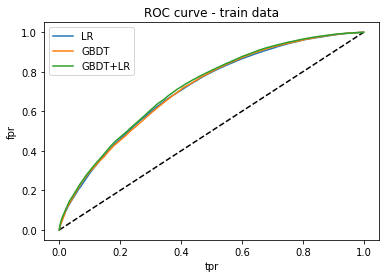

<Figure size 432x288 with 0 Axes>

(0.2, 0.6)

(0.4, 0.9)

Text(0.5, 0, 'tpr')

Text(0, 0.5, 'fpr')

Text(0.5, 1.0, 'ROC curve - train data - zoom in')

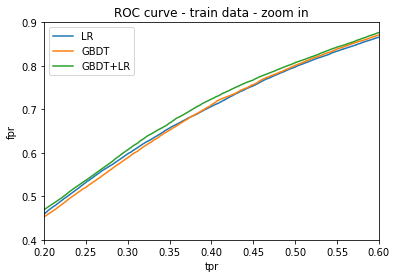

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(roc_lr[0],roc_lr[1],label='LR')
plt.plot(roc_grd[0],roc_grd[1],label='GBDT')
plt.plot(roc_grd_lm[0],roc_grd_lm[1],label='GBDT+LR')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('ROC curve - train data')
plt.legend(loc='best')
plt.show()

plt.figure(1)
plt.xlim((.2,.6))
plt.ylim((.4,.9))
plt.plot(roc_lr[0],roc_lr[1],label='LR')
plt.plot(roc_grd[0],roc_grd[1],label='GBDT')
plt.plot(roc_grd_lm[0],roc_grd_lm[1],label='GBDT+LR')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('ROC curve - train data - zoom in')
plt.legend(loc='best')
plt.show()

### Model Check - weights and features

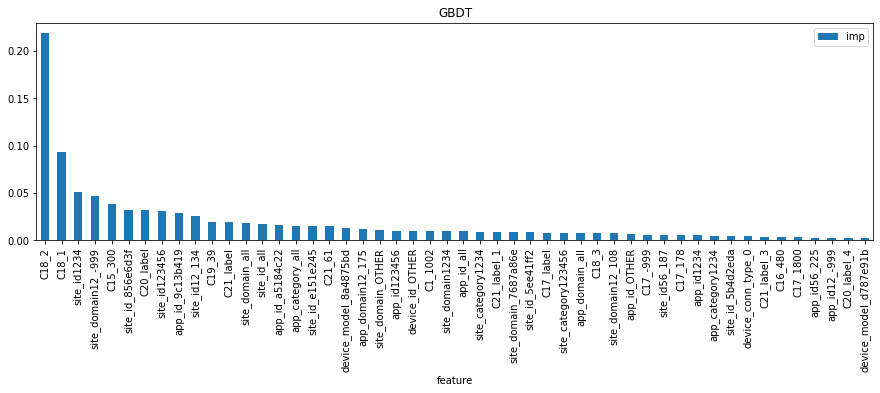

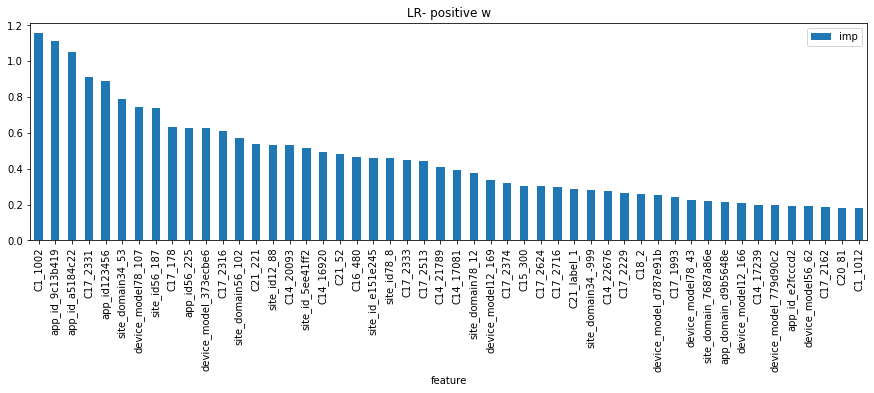

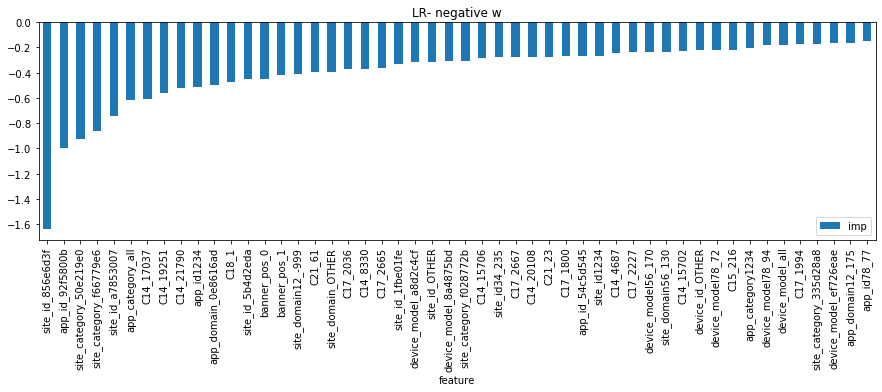

In [124]:
def analyse_clf(clf,fea,model=''):
    if model=='GBDT':
        fea_imp = pd.DataFrame([fea,clf.feature_importances_]).T
        fea_imp.columns = ['feature','imp']
        fea_imp = fea_imp[fea_imp['imp']!=0]
        fea_imp[fea_imp['imp']>0].sort_values('imp',ascending=False).set_index('feature').head(50).plot(kind='bar',title=model,figsize=(15,4))
        
    if model=='LR':
        fea_imp = pd.DataFrame([train_X.columns,model_lr.coef_[0]]).T
        fea_imp.columns = ['feature','imp']
        fea_imp
        fea_imp = fea_imp[fea_imp['imp']!=0]
        fea_imp[fea_imp['imp']>0].sort_values('imp',ascending=False).set_index('feature').head(50).plot(kind='bar',title=model+'- positive w',figsize=(15,4))
        fea_imp[fea_imp['imp']<0].sort_values('imp',ascending=True).set_index('feature').head(50).plot(kind='bar',title=model+'- negative w',figsize=(15,4))
    
analyse_clf(model_grd,train_X.columns,'GBDT')
analyse_clf(model_lr,train_X.columns,'LR')

How's feature importance in GBDT? How to compare with LR?

### Model evaluations - test set

In [99]:
preds = calc_preds(test_X)
metrics_lr,conf_mat_lr,roc_lr = calc_metrics(test_y,preds[0])
metrics_grd,conf_mat_grd,roc_grd = calc_metrics(test_y,preds[1])
metrics_grd_lm,conf_mat_grd_lm,roc_grd_lm = calc_metrics(test_y,preds[2])

In [100]:
import pandas as pd
pd.DataFrame([metrics_lr,metrics_grd,metrics_grd_lm],index=['lr','gbt','gbt_lr'])

print('confusion matrix LR:')
conf_mat_lr
print('confusion matrix GBDT:')
conf_mat_grd
print('confusion matrix GBDT_LR:')
conf_mat_grd_lm

,accuracy,auc,logloss,recall
lr,0.848566,0.711747,0.389865,0.031035
gbt,0.848311,0.712800,0.389059,0.004611
gbt_lr,0.849801,0.720873,0.386660,0.031448


confusion matrix LR:


array([[241868,   1162],
       [ 42243,   1353]], dtype=int64)

confusion matrix GBDT:


array([[242947,     83],
       [ 43395,    201]], dtype=int64)

confusion matrix GBDT_LR:


array([[242204,    826],
       [ 42225,   1371]], dtype=int64)

<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'tpr')

Text(0, 0.5, 'fpr')

Text(0.5, 1.0, 'ROC curve - test data')

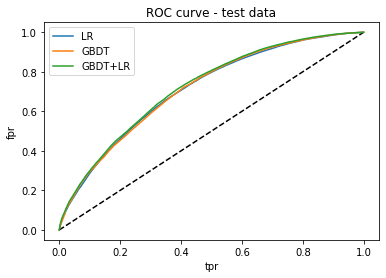

<Figure size 432x288 with 0 Axes>

(0.2, 0.6)

(0.4, 0.9)

Text(0.5, 0, 'tpr')

Text(0, 0.5, 'fpr')

Text(0.5, 1.0, 'ROC curve - test data - zoom in')

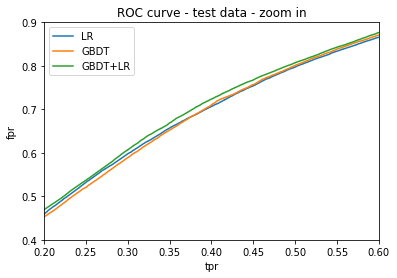

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot([0,1],[0,1],'k--')
plt.plot(roc_lr[0],roc_lr[1],label='LR')
plt.plot(roc_grd[0],roc_grd[1],label='GBDT')
plt.plot(roc_grd_lm[0],roc_grd_lm[1],label='GBDT+LR')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('ROC curve - test data')
plt.legend(loc='best')
plt.show()

plt.figure(1)
plt.xlim((.2,.6))
plt.ylim((.4,.9))
plt.plot(roc_lr[0],roc_lr[1],label='LR')
plt.plot(roc_grd[0],roc_grd[1],label='GBDT')
plt.plot(roc_grd_lm[0],roc_grd_lm[1],label='GBDT+LR')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('ROC curve - test data - zoom in')
plt.legend(loc='best')
plt.show()